In [1]:
import datetime as dt
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

In [2]:
def to_datetime(label):
    return dt.datetime.strptime(label,"%Y-%m-%d %H:%M:%S")
BNFSpotData: pd.DataFrame = pd.read_csv("banknifty5min.csv")
BNFSpotData.datetime = BNFSpotData.datetime.apply(to_datetime)
BNFSpotData["Date"] = BNFSpotData.datetime.apply(lambda x: x.date())
print(BNFSpotData.Date)
BNFSpotData["Time"] = BNFSpotData.datetime.apply(lambda x: x.time())
BNFSpotData.set_index(["Date","Time"], inplace=True)
BNFSpotData.sort_index(inplace=True)
BNFSpotData = BNFSpotData.drop(["datetime","volume"],axis=1)


0        2015-01-09
1        2015-01-09
2        2015-01-09
3        2015-01-09
4        2015-01-09
            ...    
91387    2019-12-24
91388    2019-12-24
91389    2019-12-24
91390    2019-12-24
91391    2019-12-24
Name: Date, Length: 91392, dtype: object


In [3]:
class Order:
    '''
        REPRESENTS an Order object of some type - LONG/SHORT/SQUARE
    '''
    def __init__(self,time,price,action,qty=1):
        self.timestamp = time
        self.price = price
        self.qty = qty
        self.action = action
        self.str_action=None
        if action==1:
            self.str_action = "LONG"
        elif action==-1:
            self.str_action = "SHORT"
        else:
            self.str_action = "SQUARE"
    def __str__(self):
        return "Time : {}\nPrice : {}\nQuantity : {}\nAction : {}".format(self.timestamp,self.price,self.qty,self.str_action)

In [4]:

class DirectionalStrategy:
    def __init__(self, data,strategy='1',trail=False):
        '''
            Variables : 
                1. self._log -> maintains log of buy/sell/square orders with the latest corrosponding spl/shp lpl/lph used to check the condition to give the order
                2. self._data -> the dataframe
                3. self._curr_date -> date of current row
                4. self._gap_up and self._gap_down -> shows which(or none) among trade rules are satisfied
                5. self._buy_level -> with which we compare the price when we give an order
                6. self._trailing_sl -> If trail option is true
                7. self._latest -> latest among last LPL/LPH
                8. self._LPL, self._LPH, self._sph, self._spl = arrays of all LPL,LPH,SPH,SPL
                9. self._data (I,II,0) are rows (current-1,current-2,current)
               10. self._orders -> list of all orders
               11. self.position -> current position 1: LONG/SHORT,  0: SQUARE/NONE
               12. self._pnl -> cumulative profit
               13. self._cumPnl -> array of cumulative profit for all trades till now
               14. self._PnL -> array of P&L of individual trades
               15. self._trades -> number of trades done 
               16. self._stoploss, self._trailstoploss, self._target -> strategy setting parameters
            
            Functions :
                1. run - The Driver Function of the strategy class
                2. check_gap 
                     Date Change Phemonemom:-
            We check if there was a date change between today and yesterday. If there is then we check for gap up and gap down possibilities
            along with ability to implement trading rule 2 or 3 given by variables self._gap_up and self._gap_down.
            If there is such implementation of rule 2/3  available, then do that and create a new order.

            If Date changes then on the first entry of new date we check if last entry's date is diff from today's date
            If different, get the last order and check if it was a squaring order. If it wasn't then create a new squaring order 
                3. get_sph_or_spl - if both are not there then check for both of them. Whichever found then alters a switch to other side
                        so next time we check only for the alternative one. Also for a given row, the function returns
                        if it found a new spl, sph or none.
                            a. find_spl - checks for spl conditions and returns true if spl is found at current-2 row
                            b. find_sph - similar
                4. _check_sell - checks SL Breach or TARGET acquisition and squares off
                    a. squareOff - creates a SQUARE order 
                5. _check_buy - 
                    Initiating LONG Order - Check if there is some buy level already created. If yes then if price of data0 greater than
                                the buy level then go LONG
                                If no buy_level till then, check for the next SPH>LPH and set SPH as buy_level
                                In case buy level already exists and there is a new SPH5>LPH then first make a 
                                    LONG order then set the new buy level as SPH5 and go to next row
                    Initiating SHORT Order - similar
                        a. buy_or_short - create a LONG/SHORT order as commanded
                    Also Checks for LPL/LPH formation post initiating buy/sell orders
                        a. find_lpl - checks for downward trends in SPL and SPH and if all conditions satisfy then create a LPL
                                      checks if past 3 SPL and past 3 SPH are in downtrend -- use 2 SPH if only 2 are found till then
                        b. find_lph - similar
                                 STATIC-METHODS - check_uptrend and check_downtrend - to check for trends in any 3 numbers a,b,c
                        
                6. plot -> plots some data for the strategy based on the argument supplied
                7. summary - tries to give an backtest report format summary
        '''
        self._log = []
        self._data = data
        self._curr_date  = data.iloc[0].name[0]
        self._gap_up = 0
        self._gap_down = 0
        self._buy_level = 0
        self._trailing_sl = trail
        self._latest = None
        
        self._sph = []
        self._spl = []
        self._switch = 0
        
        self._lph = (None,None)
        self._lpl = (None,None)
        
        self._dataI = None
        self._dataII = None
        self._data0 = None
        
        self.orders = []
        self.position = 0
        
        self._stoploss = 0.003
        self._trailstoploss = 0.01
        self._target = 0.005
        self._pnl = 0
        self._trades = 0
        self._PnL = []
        self._cumPnL = []
        self._square_at_1515 = True
        self._no_trade_after_1500 = True
        
    def __doc__(self):
        return '''
        @Author : Dhairya Jain
        Strategy Name - Directional Strategy
        Instrument Type - Equity
        Time Frame - {} to {}
        Strating Equity - BankNifty
        Entry Logic - Go long if uptrend and short if downtrend
        Exit Logic - Stoploss Breach or Target Acquired or EOD
        Target - {}%
        Stoploss - {}%
        Fixed Risk - ????
        Position Sizing - 1
        Instrument Type - Equity
        Leverage - None
        '''.format(self._data.iloc[0].name[0].date(),self._data.iloc[-1].name[0].date(),self._target*100,self._stoploss*100)
    def check_gap(self):
        if(self._curr_date!=self._dataI.name[0]):
            try:
                self._gap_down = (self._data0.name[0].date(),self._data0.open if self._dataI.low > self._data0.open else False)
                self._gap_up = (self._data0.name[0].date(),self._data0.open if self._dataI.high < self._data0.open else False)
            except:
                pass
            if self.position==1:
                o = self.orders[-1]
                pl = (self._dataI.close - o.price)*o.action
                self.orders.append(self.squareOff(pl,'EOD',(self._dataI.name,self._dataI.close)))
            print("\n\n\nDATE CHANGE : {}\n\n\n".format(self._curr_date))
            if self._gap_down and self._gap_down[1]:
                print("GAP DOWN : Open at {}\n\n\n".format(self._data0.open))
                return self._gap_down
            elif self._gap_up and self._gap_up[1]:
                print("GAP UP : Open at {}\n\n\n".format(self._data0.open))
                return self._gap_up
        elif (self._square_at_1515 and self._dataI.name[1]>=dt.time(15,15,0) and self.position==1):
            o = self.orders[-1]
            pl = (self._dataI.close - o.price)*o.action
            self.orders.append(self.squareOff(pl,'EOD',(self._dataI.name,self._dataI.close)))
    
            
    def get_sph_or_sph(self,i):
        new_spl_sph = 0
        if self._switch ==0:
            spl = self._find_spl()
            if not spl:
                sph = self._find_sph()
                if sph:
                    new_spl_sph = 1
                    print("FIRST FOUND : SPH :At Time {}\t with Points - {}".format(self._sph[-1][0][1],self._sph[-1][1])," -- > entry = ",i-2," && i = ",i) 
            else:
                new_spl_sph = -1
                print("FIRST FOUND : SPL :At Time {}\t with Points - {}".format(self._spl[-1][0][1],self._spl[-1][1])," -- > entry = ",i-2," && i = ",i)
        elif self._switch==1:
            sph = self._find_sph()
            if sph:
                new_spl_sph = 1
                print("NOW FOUND : SPH :At Time {}\t with Points - {}".format(self._sph[-1][0][1],self._sph[-1][1])," -- > entry = ",i-2," && i = ",i)
        else:
            spl = self._find_spl()
            if spl:
                new_spl_sph = -1
                print("NOW FOUND : SPL :At Time {}\t with Points - {}".format(self._spl[-1][0][1],self._spl[-1][1])," -- > entry = ",i-2," && i = ",i)
        #         if(new_spl_sph==-1 and len(self._spl)>=4):
        #             self._buy_level = self._spl[-1]
        #         elif(new_spl_sph==1 and len(self._sph)>=4):
        #             self._buy_level = self._sph[-1]
        return new_spl_sph
    def _check_long_short(self,i,new_spl_sph):
        if self.position !=1:      
            # If already (2,3) SPL&SPH found then find LPL and LPH
            if self._buy_level:
                if self._latest == self._lpl:
                    if self._data0.close <= self._buy_level[1]:
                        self.orders.append(self.buy_or_short((self._data0.name,self._data0.close),action=-1))
                elif self._latest == self._lph:
                    if self._data0.close >= self._buy_level[1]: 
                        self.orders.append(self.buy_or_short((self._data0.name,self._data0.close),action=1))
                    
                
                    
        if len(self._sph)>=3 or len(self._spl)>=3:
            # If already found 1 LPL OR LPH then 
            if self._latest:
                if new_spl_sph==-1 and self._latest == self._lpl and self._spl[-1][1]<self._lpl[1]:
                    self._buy_level = self._spl[-1]
                elif new_spl_sph==1 and self._latest == self._lph and self._sph[-1][1]>self._lph[1]:
                    self._buy_level = self._sph[-1]
            self._find_lph(i)
            self._find_lpl(i)
        return i+1
    def _check_square(self):
        '''
            Checks on any time if position is 1 i.e a pending buy/sell trade and checks for SL Breach
            or TGT Aquisition. If there happens to be such case then it makes a square order and returns
                TRUE.
        '''
        if self.position==1:
            for o in self.orders[-1:]:
                pl = (self._data0.close - o.price)*o.action
                if self._data0.close*o.action <= ((1-self._stoploss*o.action)*o.price) *o.action:
                    self.orders.append(self.squareOff(pl,'STOPLOSS'))
                    return True
                elif self._data0.close*o.action >= ((1+self._target*o.action)*o.price)*o.action:
                    self.orders.append(self.squareOff(pl,'TARGET'))
                    return True
        elif self.position==0:
            pass
    def buy_or_short(self, data, action):
        self.position = 1
        o = Order(data[0],data[1],action)
        latest = None
        if action == 1:
            print("BUYING At Price : {} and Time = {} --> BUY LEVEL = {}".format(o.price,o.timestamp,self._buy_level))
            latest = "LPH"
        elif action == -1:
            print("SELLING At Price : {} and Time = {} --> BUY LEVEL = {}".format(o.price,o.timestamp,self._buy_level))
            latest = "LPL"
        def D(some_tuple):
            if some_tuple == (None,None):
                return None
            else:
                return str(some_tuple[0][0].date())
        def T(some_tuple):
            if some_tuple == (None,None):
                return None
            return str(some_tuple[0][1])
                 
        self._log.append([o.timestamp[0].date(),D(self._lpl),T(self._lpl),self._lpl[1],D(self._lph),T(self._lph),self._lph[1]
                ,D(self._spl[-3]),T(self._spl[-3]),self._spl[-3][1],D(self._spl[-2]),T(self._spl[-2]),self._spl[-2][1],D(self._spl[-1]),T(self._spl[-1]),self._spl[-1][1]
                          
                ,D(self._sph[-3]),T(self._sph[-3]),self._sph[-3][1],D(self._sph[-2]),T(self._sph[-2]),self._sph[-2][1],D(self._sph[-1]),T(self._sph[-1]),self._spl[-1][1]
                          ,o.price,o.timestamp[1],o.str_action,
                D(self._buy_level),T(self._buy_level),self._buy_level[1]
                         ])
        #         ,self._latest,self._spl[-1],self._sph[-1]
        #         self._cumPnL.append(self._pnl)
        return o
    def squareOff(self,pl,exit,data=None):
        self._PnL.append(pl)
        self._pnl += pl
        self._cumPnL.append(self._pnl)
        self._trades +=1
                    
        data = data or (self._data0.name,self._data0.close)
        pivot_price = (self._dataI.high+self._dataI.low+self._dataI.close)/3
        r1 = 2*pivot_price - self._dataI.low
        self.position = 0
        stoploss=((1-self._stoploss*self.orders[-1].action)*self.orders[-1].price) *self.orders[-1].action
        o = Order(data[0],data[1],action=0)
        print("SQUARING at Price : {}\nTime : {}".format(data[1],data[0]))
        self._log[-1].append(o.price)
        self._log[-1].append(stoploss)
        self._log[-1].append(exit)
        self._log[-1].append(pl)   
        #         ([o.timestamp[0].date()-dt.timedelta(days=1),o.timestamp[0].date(),pivot_price,r1,
        #                 self._data0.open,self._data0.high,self._data0.low,self._data0.close,o.price,o.timestamp[1],
        #                           o.str_action,self._latest,self._spl[-1],self._sph[-1]])
        return o
    ########################################################################################################
    '''
        Functions for checking LPL- LPH
    '''
    @staticmethod
    def check_uptrend(a,b,c):
        if c>b and b>a:
            return True
        else:
            return False
    
    @staticmethod
    def check_downtrend(a,b,c):
        if c<b and b<a:
            return True
        else:
            return False
    def _find_lph(self,i):
        try:
            a,b,c = self._sph[-3:]
            a,b,c = a[1],b[1],c[1]
        except:
            b,c = self._sph[-2:]
            b,c = b[1],c[1]
            a = b-1
            if len(self._sph)<3:
                return
        try:
            p,q,r = self._spl[-3:]
            p,q,r = p[1],q[1],r[1]
        except ValueError:
            q,r = self._spl[-2:]
            q,r = q[1],r[1]
            p = q - 1
        if self.check_uptrend(a,b,c) and self.check_uptrend(p,q,r):
            if True or self._data0.close<=self._spl[-1][1]:
                if self._sph[-1] != self._lph:
                    self._lph = self._sph[-1]
                    self._latest = self._lph
        #                     self._LPH.append(self._lph)
                    print("LPH Found : {} --> {}\n".format(self._lph,i))
    def _find_lpl(self,i):
        try:
            a,b,c = self._spl[-3:]
            a,b,c = a[1],b[1],c[1]
        except:
            b,c = self._spl[-2:]
            b,c = b[1],c[1]
            a = b + 1
            if len(self._spl)<3:
                return
        
        try:
            p,q,r = self._sph[-3:]
            p,q,r = p[1],q[1],r[1]
        except ValueError:
            q,r = self._sph[-2:]
            q,r = q[1],r[1]
            p = q + 1        
        if self.check_downtrend(a,b,c) and self.check_downtrend(p,q,r):
            if True or self._data0.close>=self._sph[-1][1]:
                if self._spl[-1] != self._lpl:
                    self._lpl = self._spl[-1]
                    self._latest = self._lpl
        #                     self._LPL.append(self._lpl)
                    print("LPL Found : {} --> {}\n".format(self._lpl,i))
    #######################################################################################################
    '''
        FUNCTIONS FOR FINDING SPL SPH
    '''
    def _find_spl(self):
        if self._dataI.high > self._dataII.high and self._dataI.close > self._dataII.close:
            if self._data0.high > self._dataI.high and self._data0.close > self._dataI.close:
                self._spl.append((self._dataII.name, self._dataII.low))
            #                 if len(self._spl)>=3:
            #                     self._curr_spl +=1
                self._switch = 1
                return True
    def _find_sph(self):
        if self._dataI.low < self._dataII.low and self._dataI.close < self._dataII.close:
            if self._data0.low < self._dataI.low and self._data0.close < self._dataI.close:
                self._sph.append((self._dataII.name,self._dataII.high))
            #                 if len(self._sph)>=3:
            #                     self._curr_sph +=1
                self._switch = -1
                return True
    #######################################################################################################
    def plot(self,mode  = 'pnl'):
        if mode=='pivots':
            t = pd.DataFrame(self._sph, columns=['DT','Val'])
            ax1 = t.plot(x="DT",y="Val", style='.', c="DarkBlue", label = "SPH")
            
            x = pd.DataFrame(self._spl, columns=["DT",'Val'])
            x.plot(x="DT",y="Val", style='.',c="Red", ax= ax1, label="SPL")
            #             lpl = pd.DataFrame(self._LPL, columns=["DT",'Val'])
            #             lpl.plot(x="DT",y="Val", style='.',c="Black", ax= ax1, label="LPL")
            #             lph = pd.DataFrame(self._LPH, columns=["DT",'Val'])
            #             lph.plot(x="DT",y="Val", style='.',c="Yellow", ax= ax1, label="LPH")
        else:
            x = pd.Series(self._PnL)
            print(x)
            x.plot()
            #         trunc = lambda x: x.strip("()").split(" ")[0]
            #         tl = [ trunc(t.get_text()) for t in ax.get_xticklabels()]
            #         ax.set_xticklabels(tl)
    
    ###########################################################################################################
    '''
        Now GAP RULES LONG SHORT FUNCTIONS for trade rules 2 and 3
    '''
    def gap_up_buy(self):
        '''
            Check for position gain opportunity. Execute SHORT order of Trade Rule 2
        '''
        if self.position!=1:
            if self._data0.close<self._buy_level[1]:
                self.orders.append(self.buy_or_short((self._data0.name,self._data0.close),-1))
                return True
        return False
    def gap_down_buy(self):
        '''
            Check for position gain opportunity. Execute LONG order of Trade Rule 3
        '''
        if self.position!=1:
            if self._data0.close>self._buy_level[1]:
                self.orders.append(self.buy_or_short((self._data0.name,self._data0.close),1))
                return True
        return False
    ########################################################################################################
    def run(self):
        i = 2
        print("Begining with data entry : %d\n\n\n\n"%i)
        while(i<len(self._data)):
            ###############################################################################################
            '''
                Set initial driver variables which will be used multiple times in this iteration
            '''
            self._data0 = self._data.iloc[i]
            self._curr_date = self._data.iloc[i].name[0]
            self._dataI = self._data.iloc[i-1]
            self._dataII = self._data.iloc[i-2]
            ################################################################################################
            #Check for day change and gap conditions
            ''' 
                Gap Rules says if there was a gap up/down situation created on the current row. If Yes then
                go 2 rows ahead to directly check for spl/sph
            '''
            gap_rules = self.check_gap()
            # if gap_rules:
            #     i+=2
            #     continue             
            ################################################################################################
            if (len(self.orders)==0 or not(len(self.orders)>0 and self.orders[-1].timestamp[0].date() == self._curr_date)):
                '''If last was made today or then first trade of month has occured.'''
                if self._gap_up and self._gap_up[0]==self._curr_date and self._gap_up[1]!=False:
                    '''
                    If the last gap up recorded was today then check if there was already any buy level set today.
                    If set today then it means that spl is already encountered and so go execute sell order. Finally,
                        also check if today a new spl/sph was identified or any LPH/LPL and then continue for next i
                    
                    If not set today then normally search for any new spl/sph. If spl then set it as buy level.
                    '''

                    if self._lph[1] and self._lph[1] < self._gap_up[1]:
                        if self._buy_level and self._buy_level[0][0].date() == self._curr_date:
                            self.gap_up_buy()
                            new_spl_sph  = self.get_sph_or_sph(i)
                        else:
                            self._switch = 0
                            new_spl_sph  = self.get_sph_or_sph(i)
                            if(new_spl_sph==-1):
                                self._buy_level = self._spl[-1]
                                i+=1
                                continue
                        if len(self._sph)>=3 or len(self._spl)>=3:
                            self._find_lph(i)
                            self._find_lpl(i)   
                        i+=1
                        continue
                elif self._gap_down and self._gap_down[0]==self._curr_date and self._gap_down[1]!=False:
                    '''
                    If the last gap down recorded was today then check if there was already any buy level set today.
                    If set today then it means that sph is already encountered and so go execute buy order. Finally,
                        also check if today a new spl/sph was identified or any LPH/LPL and then continue for next i
                    
                    If not set today then normally search for any new spl/sph. If sph then set it as buy level.
                    '''
                    if self._lpl[1] and self._lpl[1] > self._gap_down[1]:
                        if self._buy_level and self._buy_level[0][0].date() == self._curr_date:
                            self.gap_down_buy()
                        else:
                            new_spl_sph  = self.get_sph_or_sph(i)
                            if(new_spl_sph==1):
                                self._buy_level = self._sph[-1]
                                i+=1
                                continue
                        new_spl_sph  = self.get_sph_or_sph(i)
                        if len(self._sph)>=3 or len(self._spl)>=3:
                            self._find_lph(i)
                            self._find_lpl(i) 
                        i+=1
                        continue        
            
            
            ####################################################################################################
            '''
                Now case remains that if there was no gap up/down today or if there was a gap up/down then first
                    order i.e. a buy/sell is already executed. So now we need to check if we can square and make
                    a trade after checking for spl/sph
                Now irrespective of anything, we check this i for new spl/sph
            '''
            #Find the next SPL SPH
            new_spl_sph  = self.get_sph_or_sph(i)
            #####################################################################################################
            # Sell if Already Bought  
            '''
                If we get to sell now then make i++ and move to next row
            '''
            squared = self._check_square()
            if squared:
                i+=1
                continue
            ####################################################################################################
            '''
                If no trade after 3PM is False or if it is true then row time is <=3PM -> Check for opportunity
                    to create any position
            '''
            if not self._no_trade_after_1500 or (self._no_trade_after_1500 and self._data0.name[1]<=dt.time(15,0,0) ):
                i = self._check_long_short(i,new_spl_sph) 
            else:
                self._find_lph(i)
                self._find_lpl(i)
                i+=1
        #########   PROCESS THE LAST ROW OF DATA ###############
        
        if len(self.orders)>0 and self.orders[-1].str_action != "SQUARE":
            o = self.orders[-1]
            pl = (self._dataI.close - o.price)*o.action
            self.orders.append(self.squareOff(pl,(self._data0.name,self._data0.close),'EOD'))
        #########   CREATE LOG array as a DATAFRAME ############
        self._log = pd.DataFrame(self._log,columns=['Present_Date','LPL Date','LPL Time','LPL Value','LPH Date','LPH Time','LPH Value',
                'SPL1 Date','SPL1 Time','SPL1 - Value','SPL2 Date','SPL2 Time','SPL2 - Value','SPL3 Date','SPL3 Time','SPL3 - Value',
                'SPH1 Date','SPH1 Time','SPH1 - Value','SPH2 Date','SPH2 Time','SPH2 - Value','SPH3 Date','SPL3 Time','SPH3 - Value',
                                                    'BuyingPrice','BuyingTime',
                    'Order Type','BuyLevel Date','BuyLevel Time','BuyingLevel',
                    'SellingPrice','Stoploss','Exit','Individual P&L'])
        #         ,'Latest LPH or LPL','Last SPL','Last SPH'
        self._log['Cumulative P&L'] = pd.Series(self._cumPnL)
        #########   Print Net Profit-Loss and Summary ##########
        print("\n\n\n\nNET PROFIT AND LOSS : %f"%self._pnl)
        print(self.summary())
    def summary(self):
        self._PnL = np.array(self._PnL)
        profit_trades = 0
        loss_trades = 0
        max_profit = self._PnL[0]
        max_loss = self._PnL[0]
        
        ml,mw=0, 0
        max_consecutive_wins = 0
        max_consecutive_loss = 0
        gross_profit = 0
        gross_loss = 0
        for i in range(len(self._PnL)):
            if self._PnL[i]>0:
                gross_profit += self._PnL[i]
                profit_trades+=1
                max_profit = max(max_profit,self._PnL[i])
                try:
                    if self._PnL[i-1]>0:
                        mw+=1
                        max_consecutive_wins=max(max_consecutive_wins,mw)
                    else:
                        mw=1
                except:        
                    pass
            elif self._PnL[i]<0:
                gross_loss += self._PnL[i]
                loss_trades+=1
                max_loss = min(max_loss,self._PnL[i])
                try:
                    if self._PnL[i-1]<0:
                        ml+=1
                        max_consecutive_loss=max(max_consecutive_loss,ml)
                    else:
                        ml=1
                except:
                    pass
        avg_profit = gross_profit/profit_trades
        avg_loss = gross_loss/loss_trades
        return '''
        
        NET PROFIT           : {}
        TOTAL TRADES         : {}
        MAX PROFIT           : {}
        MAX LOSS             : {}
        PROFITABLE TRADES    : {}
        LOSS TRADES          : {}
        AVG PROFIT           : {}
        AVG LOSS             : {}
        MAX CONSECUTIVE WINS : {}
        MAX CONSECUTIVE LOSS : {}
        
        '''.format(self._pnl,
                   len(self._PnL),
                   max_profit,
                   max_loss,
                   profit_trades,
                   loss_trades,
                   avg_profit,
                   avg_loss,
                   max_consecutive_wins,
                   max_consecutive_loss)


In [21]:
strategy = DirectionalStrategy(BNFSpotData.iloc[(BNFSpotData.index.get_level_values('Date') >= dt.datetime(2019,11,1) ) & (BNFSpotData.index.get_level_values('Date') < dt.datetime(2019,12,20))])
strategy.run()

Begining with data entry : 2




FIRST FOUND : SPL :At Time 09:40:00	 with Points - 30144.7  -- > entry =  5  && i =  7
NOW FOUND : SPH :At Time 10:05:00	 with Points - 30295.45  -- > entry =  10  && i =  12
NOW FOUND : SPL :At Time 10:40:00	 with Points - 30136.3  -- > entry =  17  && i =  19
NOW FOUND : SPH :At Time 12:15:00	 with Points - 30350.65  -- > entry =  36  && i =  38
NOW FOUND : SPL :At Time 13:10:00	 with Points - 30215.25  -- > entry =  47  && i =  49
NOW FOUND : SPH :At Time 13:35:00	 with Points - 30301.1  -- > entry =  52  && i =  54
NOW FOUND : SPL :At Time 14:30:00	 with Points - 30200.3  -- > entry =  63  && i =  65
NOW FOUND : SPH :At Time 14:50:00	 with Points - 30353.1  -- > entry =  67  && i =  69
NOW FOUND : SPL :At Time 15:05:00	 with Points - 30290.2  -- > entry =  70  && i =  72



DATE CHANGE : 2019-11-04 00:00:00



GAP UP : Open at 30415.9



NOW FOUND : SPH :At Time 10:15:00	 with Points - 30606.6  -- > entry =  87  && i =  89
NOW FOUND : SPL :At Time 1

NOW FOUND : SPH :At Time 14:55:00	 with Points - 31131.75  -- > entry =  743  && i =  745



DATE CHANGE : 2019-11-18 00:00:00



GAP UP : Open at 31036.8



NOW FOUND : SPL :At Time 15:20:00	 with Points - 30969.4  -- > entry =  748  && i =  750
NOW FOUND : SPH :At Time 09:20:00	 with Points - 31202.9  -- > entry =  751  && i =  753
NOW FOUND : SPL :At Time 10:20:00	 with Points - 30972.75  -- > entry =  763  && i =  765
NOW FOUND : SPH :At Time 11:15:00	 with Points - 31022.35  -- > entry =  774  && i =  776
NOW FOUND : SPL :At Time 11:35:00	 with Points - 30915.05  -- > entry =  778  && i =  780
NOW FOUND : SPH :At Time 12:15:00	 with Points - 31004.95  -- > entry =  786  && i =  788
NOW FOUND : SPL :At Time 12:25:00	 with Points - 30924.1  -- > entry =  788  && i =  790
NOW FOUND : SPH :At Time 13:10:00	 with Points - 31026.1  -- > entry =  797  && i =  799
NOW FOUND : SPL :At Time 15:05:00	 with Points - 30973.45  -- > entry =  820  && i =  822



DATE CHANGE : 2019-11-19 00:00:00

NOW FOUND : SPH :At Time 10:30:00	 with Points - 31742.35  -- > entry =  1215  && i =  1217
LPH Found : ((Timestamp('2019-11-26 00:00:00'), datetime.time(10, 30)), 31742.35) --> 1217

NOW FOUND : SPL :At Time 11:10:00	 with Points - 31663.25  -- > entry =  1223  && i =  1225
NOW FOUND : SPH :At Time 11:35:00	 with Points - 31690.65  -- > entry =  1228  && i =  1230
NOW FOUND : SPL :At Time 12:25:00	 with Points - 31695.1  -- > entry =  1238  && i =  1240
NOW FOUND : SPH :At Time 13:10:00	 with Points - 31759.95  -- > entry =  1247  && i =  1249
NOW FOUND : SPL :At Time 13:25:00	 with Points - 31677.35  -- > entry =  1250  && i =  1252
NOW FOUND : SPH :At Time 13:40:00	 with Points - 31753.15  -- > entry =  1253  && i =  1255
SQUARING at Price : 31521.05
Time : (Timestamp('2019-11-26 00:00:00'), datetime.time(14, 35))
NOW FOUND : SPL :At Time 14:40:00	 with Points - 31467.15  -- > entry =  1265  && i =  1267



DATE CHANGE : 2019-11-27 00:00:00



BUYING At Price : 31846.25 and Time = (

NOW FOUND : SPH :At Time 09:25:00	 with Points - 31344.8  -- > entry =  1952  && i =  1954
NOW FOUND : SPL :At Time 09:45:00	 with Points - 31269.0  -- > entry =  1956  && i =  1958
NOW FOUND : SPH :At Time 10:05:00	 with Points - 31351.5  -- > entry =  1960  && i =  1962
NOW FOUND : SPL :At Time 11:30:00	 with Points - 31234.65  -- > entry =  1977  && i =  1979
NOW FOUND : SPH :At Time 11:50:00	 with Points - 31310.05  -- > entry =  1981  && i =  1983
SQUARING at Price : 31376.25
Time : (Timestamp('2019-12-10 00:00:00'), datetime.time(13, 0))
SELLING At Price : 31253.8 and Time = (Timestamp('2019-12-10 00:00:00'), datetime.time(14, 0)) --> BUY LEVEL = ((Timestamp('2019-12-06 00:00:00'), datetime.time(14, 35)), 31265.0)
SQUARING at Price : 31165.5
Time : (Timestamp('2019-12-10 00:00:00'), datetime.time(15, 15))



DATE CHANGE : 2019-12-11 00:00:00



GAP DOWN : Open at 31151.65



NOW FOUND : SPL :At Time 15:20:00	 with Points - 31149.65  -- > entry =  2023  && i =  2025
SELLING At Pri

In [22]:
strategy._log

,Present_Date,LPL Date,LPL Time,LPL Value,LPH Date,LPH Time,LPH Value,SPL1 Date,SPL1 Time,SPL1 - Value,...,BuyingTime,Order Type,BuyLevel Date,BuyLevel Time,BuyingLevel,SellingPrice,Stoploss,Exit,Individual P&L,Cumulative P&L
0,2019-11-07,2019-11-06,10:50:00,30015.75,2019-11-06,14:55:00,30685.25,2019-11-06,13:55:00,30514.85,...,09:45:00,SHORT,2019-11-07,09:25:00,30712.05,30493.35,-30764.21660,TARGET,178.85,178.85
1,2019-11-07,2019-11-06,10:50:00,30015.75,2019-11-07,09:35:00,30818.90,2019-11-07,10:20:00,30559.75,...,14:00:00,LONG,2019-11-07,09:25:00,30712.05,30629.80,30643.44305,STOPLOSS,-105.85,73.00
2,2019-11-08,2019-11-06,10:50:00,30015.75,2019-11-07,09:35:00,30818.90,2019-11-07,12:40:00,30465.25,...,09:50:00,LONG,2019-11-07,09:25:00,30712.05,30913.75,30650.17280,TARGET,171.35,244.35
3,2019-11-08,2019-11-06,10:50:00,30015.75,2019-11-07,09:35:00,30818.90,2019-11-07,13:50:00,30600.05,...,12:15:00,LONG,2019-11-07,09:25:00,30712.05,31095.10,30831.92590,TARGET,170.40,414.75
4,2019-11-08,2019-11-06,10:50:00,30015.75,2019-11-07,09:35:00,30818.90,2019-11-07,13:50:00,30600.05,...,13:25:00,LONG,2019-11-07,09:25:00,30712.05,30877.35,30928.13640,STOPLOSS,-143.85,270.90
5,2019-11-13,2019-11-06,10:50:00,30015.75,2019-11-08,13:20:00,31107.75,2019-11-08,10:40:00,30688.95,...,09:15:00,LONG,2019-11-08,13:20:00,31107.75,31018.00,31063.22990,STOPLOSS,-138.70,132.20
6,2019-11-13,2019-11-13,13:00:00,30835.10,2019-11-08,13:20:00,31107.75,2019-11-13,11:05:00,30898.85,...,13:15:00,SHORT,2019-11-08,13:20:00,31107.75,30698.60,-30969.78145,TARGET,178.55,310.75
7,2019-11-13,2019-11-13,13:00:00,30835.10,2019-11-08,13:20:00,31107.75,2019-11-13,11:05:00,30898.85,...,14:45:00,SHORT,2019-11-08,13:20:00,31107.75,30517.10,-30787.08500,TARGET,177.90,488.65
8,2019-11-14,2019-11-13,13:00:00,30835.10,2019-11-08,13:20:00,31107.75,2019-11-13,11:05:00,30898.85,...,09:15:00,SHORT,2019-11-08,13:20:00,31107.75,30383.05,-30680.11505,TARGET,205.30,693.95
9,2019-11-14,2019-11-13,13:00:00,30835.10,2019-11-08,13:20:00,31107.75,2019-11-13,11:05:00,30898.85,...,09:40:00,SHORT,2019-11-08,13:20:00,31107.75,30450.05,-30447.21845,STOPLOSS,-93.90,600.05


<IPython.core.display.Javascript object>


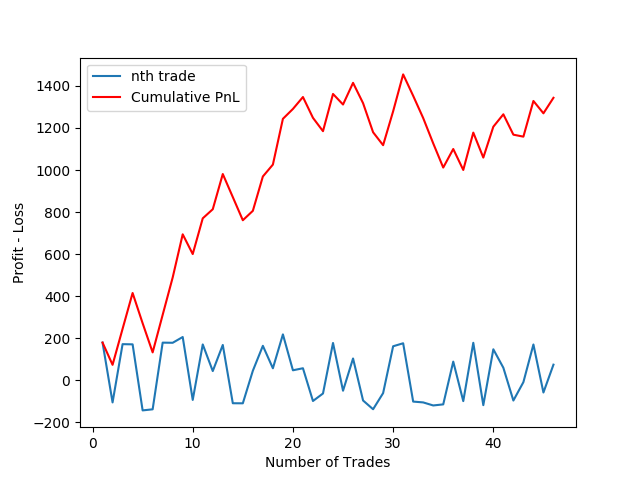

Text(0, 0.5, 'Profit - Loss')

In [23]:
%matplotlib notebook
plt.plot(range(1,len(strategy._PnL)+1),strategy._PnL,label='nth trade')
# a = []
# for i in range(1,len(strategy._cumPnL),2):
#     a.append(strategy._cumPnL[i])
plt.plot(range(1,len(strategy._cumPnL)+1),strategy._cumPnL,'r',label='Cumulative PnL')
plt.legend()
plt.xlabel("Number of Trades")
plt.ylabel("Profit - Loss")

<IPython.core.display.Javascript object>


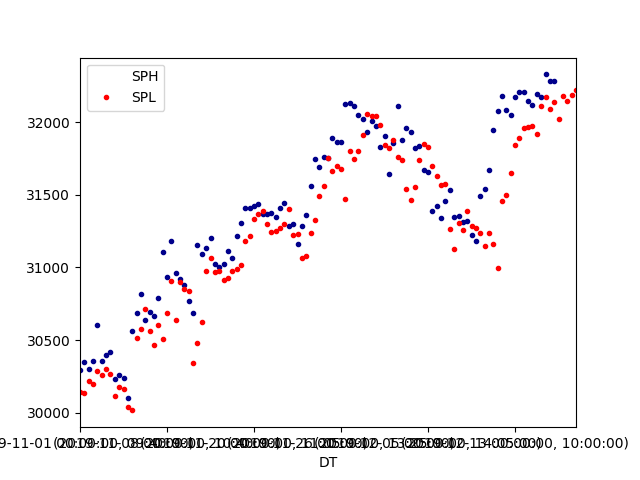

In [24]:
strategy.plot('pivots')

In [9]:
print(strategy.__doc__())


        @Author : Dhairya Jain
        Strategy Name - Directional Strategy
        Instrument Type - Equity
        Time Frame - 2019-11-01 to 2019-11-29
        Strating Equity - BankNifty
        Entry Logic - Go long if uptrend and short if downtrend
        Exit Logic - Stoploss Breach or Target Acquired or EOD
        Target - 0.5%
        Stoploss - 0.3%
        Fixed Risk - ????
        Position Sizing - 1
        Instrument Type - Equity
        Leverage - None
        


In [25]:
strategy._log.to_csv('tradelog.csv')

In [70]:
(strategy._log).to_csv("tradelog.csv")

In [182]:
strategy._lpl[0]

(Timestamp('2019-12-23 00:00:00'), datetime.time(14, 35))

In [64]:
strategy._lph[0]

(Timestamp('2019-08-09 00:00:00'), datetime.time(10, 40))

In [65]:
pd.DataFrame(strategy._LPL, columns=["DT",'Val'])

,DT,Val
0,"(2019-08-01 00:00:00, 14:00:00)",28309.25
1,"(2019-08-01 00:00:00, 14:50:00)",28081.30


<IPython.core.display.Javascript object>


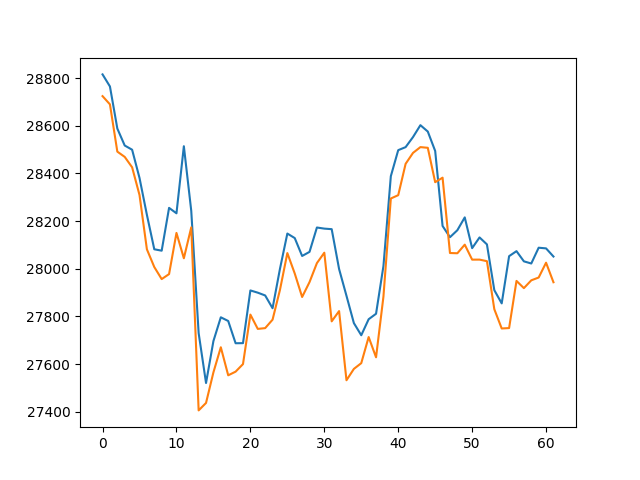

In [19]:
%matplotlib notebook
a = pd.DataFrame(strategy._sph)
a.set_index(a[0])
# plt.scatter(x = (a[0].apply(lambda x: str(x))), y = a[1])
b = pd.DataFrame(strategy._spl)
b.set_index(b[0])
# plt.scatter(x = (b[0].apply(lambda x: str(x))), y = b[1])
plt.plot(a[1])
plt.plot(b[1])

In [39]:
%matplotlib notebook


a = BNFSpotData.iloc[BNFSpotData.index.get_level_values('Date') == dt.datetime(2019,2,8)]

<IPython.core.display.Javascript object>


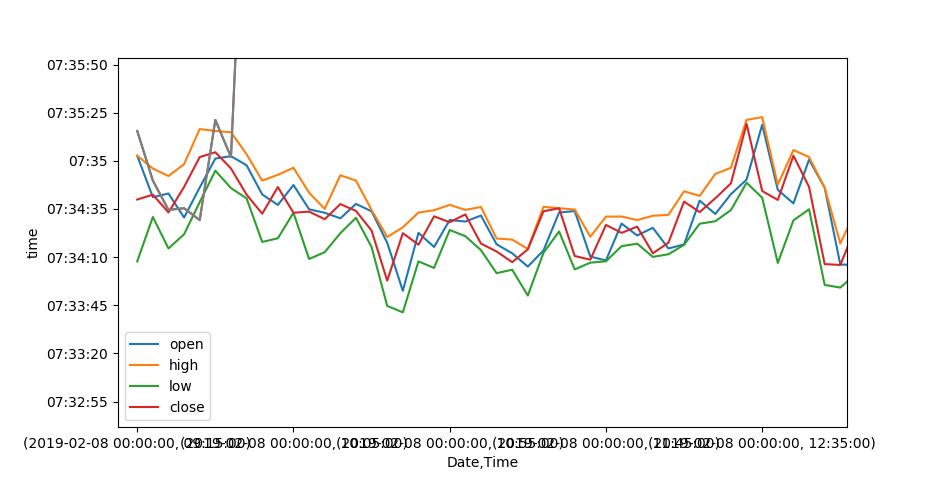

In [40]:
BNFSpotData.iloc[BNFSpotData.index.get_level_values('Date') == dt.datetime(2019,2,8)].plot()

In [27]:
df = pd.DataFrame({'a':[2,3,5], 'b':[1,2,3], 'c':[12,13,14]})
df.set_index(['a','b'], inplace=True)
display(df)
s = df.iloc[1]

,,c
a,b,
2,1,12
3,2,13
5,3,14


In [96]:
BNFSpotData.iloc[BNFSpotData.index.get_level_values('Date') == dt.datetime(2019,2,11)]

open      high       low     close
Date       Time                                            
2019-02-11 09:15:00  27240.50  27243.15  27179.95  27226.60
           09:20:00  27227.20  27227.20  27187.70  27218.90
           09:25:00  27218.45  27218.45  27193.95  27209.45
           09:30:00  27209.65  27224.85  27189.45  27207.45
           09:35:00  27206.80  27236.60  27203.95  27235.45
...                       ...       ...       ...       ...
           15:05:00  27209.75  27215.10  27193.10  27204.70
           15:10:00  27205.55  27218.45  27203.25  27213.10
           15:15:00  27214.85  27243.00  27194.55  27237.15
           15:20:00  27235.65  27247.35  27230.40  27236.90
           15:25:00  27236.50  27272.45  27236.50  27259.95

[75 rows x 4 columns]

In [29]:
s.name[1]

2

In [25]:
BNFSpotData.iloc[BNFSpotData.index.get_level_values('Date') == dt.datetime(2019,2,8)].iloc[30].name[1]

datetime.time(11, 45)

In [ ]:
print('''
Date : {}
    SPL 1 : {}
    SPL 2 : {}
    SPL 3 : {}
        
    SPH 1 : {}
    SPH 2 : {}
    SPH 3 : {}
    
    LPL   : {}
    LPH   : {}
                '''.format(self._date,self._spl0,self._spl1,self._spl2,self._sph0,self._sph1,self._sph2,self._lpl,self._lph))
 
        self._sph0 = None
        self._spl0 = None
        self._sph1 = None
        self._spl1 = None
        self._sph2 = None
        self._spl2 = None
        self._sph3 = None
        self._spl3 = None
                 

In [67]:
for i in BNFSpotData.index.levels[0][0]:
    strategy = DirectionalStrategy(BNFSpotData.loc[i],i)
    strategy.run()

Date : 2015-01-09 00:00:00  ---- No Trade Today
Date : 2015-01-12 00:00:00  ---- No Trade Today
Date : 2015-01-13 00:00:00  ---- No Trade Today
Date : 2015-01-14 00:00:00  ---- No Trade Today

Date : 2015-01-15 00:00:00
    SPL 1 : 19159.65
    SPL 2 : 19115.4
    SPL 3 : 19069.1
        
    SPH 1 : 19285.15
    SPH 2 : 19209.25
    SPH 3 : 19174.1
    
    LPL   : 19069.1
    LPH   : None
            
Date : 2015-01-19 00:00:00  ---- No Trade Today
Date : 2015-01-20 00:00:00  ---- No Trade Today
Date : 2015-01-21 00:00:00  ---- No Trade Today
Date : 2015-01-22 00:00:00  ---- No Trade Today
Date : 2015-01-23 00:00:00  ---- No Trade Today
Date : 2015-01-27 00:00:00  ---- No Trade Today

Date : 2015-01-28 00:00:00
    SPL 1 : 20477.25
    SPL 2 : 20486.5
    SPL 3 : 20516.0
        
    SPH 1 : 20547.35
    SPH 2 : 20574.1
    SPH 3 : 20907.55
    
    LPL   : None
    LPH   : 20907.55
            

Date : 2015-01-29 00:00:00
    SPL 1 : 20338.95
    SPL 2 : 20393.0
    SPL 3 : 20420.1


<IPython.core.display.Javascript object>


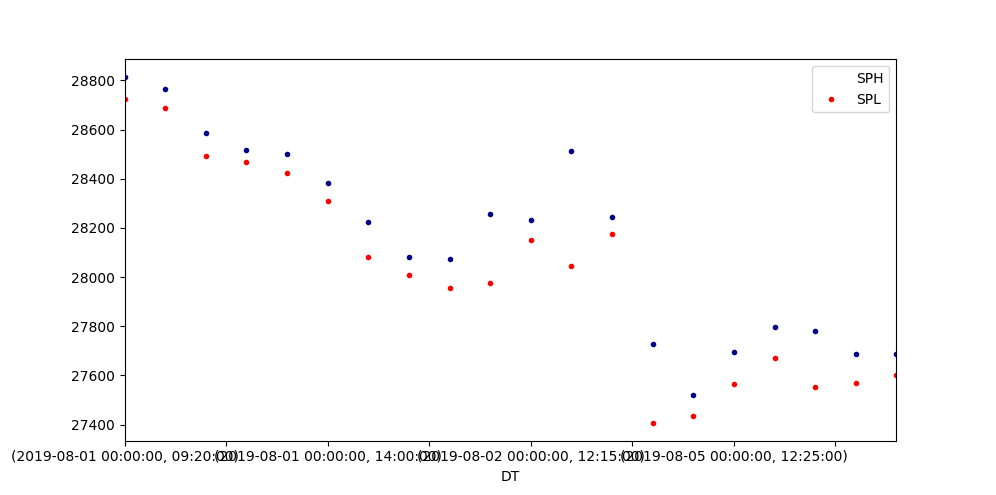

(Timestamp('2019-08-01 00:00:00'), datetime.time(10, 0))

In [143]:
def a():
    a.i = 0
    while (a.i<10):
        b()
def b():
    if(a.i==5):
        print("Hurray")
    a.i+=1
    if(a.i%2 ==0):
        print(i)
    else:
        continue

SyntaxError: 'continue' not properly in loop (<ipython-input-143-711cf6155c21>, line 15)

In [76]:
a = pd.DataFrame([[1,2,3,4],[5,6,7,8],[9,10,11,12]],columns=['a','b','c','d'])
a

,a,b,c,d
0,1,2,3,4
1,5,6,7,8
2,9,10,11,12


In [81]:
a.iloc[-1].loc['b','c'] = 100,200

In [83]:
a.append([900,2.45])

,a,b,c,d,0
0,1.0,2.0,3.0,4.0,NaN
1,5.0,6.0,7.0,8.0,NaN
2,9.0,100.0,200.0,12.0,NaN
0,NaN,NaN,NaN,NaN,900.00
1,NaN,NaN,NaN,NaN,2.45


In [85]:
b = [[1,2,3,4],[5,6,7,8],[9,10,11,12]]

In [86]:
b.append([100,200])

In [87]:
pd.DataFrame(b)

,0,1,2,3
0,1,2,3.0,4.0
1,5,6,7.0,8.0
2,9,10,11.0,12.0
3,100,200,NaN,NaN


In [92]:
b

[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [100, 200]]

In [93]:
b[-1]

[100, 200]

In [96]:
b[-1].append(1,2)

TypeError: append() takes exactly one argument (2 given)

In [95]:
b

[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [100, 200, [1, 2]]]

In [41]:

class DirectionalStrategy:
    def __init__(self, data,strategy='1',trail=False):
        '''
            Variables : 
                1. self._log -> maintains log of buy/sell/square orders with the latest corrosponding spl/shp lpl/lph used to check the condition to give the order
                2. self._data -> the dataframe
                3. self._curr_date -> date of current row
                4. self._gap_up and self._gap_down -> shows which(or none) among trade rules are satisfied
                5. self._buy_level -> with which we compare the price when we give an order
                6. self._trailing_sl -> If trail option is true
                7. self._latest -> latest among last LPL/LPH
                8. self._LPL, self._LPH, self._sph, self._spl = arrays of all LPL,LPH,SPH,SPL
                9. self._data (I,II,0) are rows (current-1,current-2,current)
               10. self._orders -> list of all orders
               11. self.position -> current position 1: LONG/SHORT,  0: SQUARE/NONE
               12. self._pnl -> cumulative profit
               13. self._cumPnl -> array of cumulative profit for all trades till now
               14. self._PnL -> array of P&L of individual trades
               15. self._trades -> number of trades done 
               16. self._stoploss, self._trailstoploss, self._target -> strategy setting parameters
            
            Functions :
                1. run - The Driver Function of the strategy class
                2. check_gap 
                     Date Change Phemonemom:-
            We check if there was a date change between today and yesterday. If there is then we check for gap up and gap down possibilities
            along with ability to implement trading rule 2 or 3 given by variables self._gap_up and self._gap_down.
            If there is such implementation of rule 2/3  available, then do that and create a new order.

            If Date changes then on the first entry of new date we check if last entry's date is diff from today's date
            If different, get the last order and check if it was a squaring order. If it wasn't then create a new squaring order 
                3. get_sph_or_spl - if both are not there then check for both of them. Whichever found then alters a switch to other side
                        so next time we check only for the alternative one. Also for a given row, the function returns
                        if it found a new spl, sph or none.
                            a. find_spl - checks for spl conditions and returns true if spl is found at current-2 row
                            b. find_sph - similar
                4. _check_sell - checks SL Breach or TARGET acquisition and squares off
                    a. squareOff - creates a SQUARE order 
                5. _check_buy - 
                    Initiating LONG Order - Check if there is some buy level already created. If yes then if price of data0 greater than
                                the buy level then go LONG
                                If no buy_level till then, check for the next SPH>LPH and set SPH as buy_level
                                In case buy level already exists and there is a new SPH5>LPH then first make a 
                                    LONG order then set the new buy level as SPH5 and go to next row
                    Initiating SHORT Order - similar
                        a. buy_or_short - create a LONG/SHORT order as commanded
                    Also Checks for LPL/LPH formation post initiating buy/sell orders
                        a. find_lpl - checks for downward trends in SPL and SPH and if all conditions satisfy then create a LPL
                                      checks if past 3 SPL and past 3 SPH are in downtrend -- use 2 SPH if only 2 are found till then
                        b. find_lph - similar
                                 STATIC-METHODS - check_uptrend and check_downtrend - to check for trends in any 3 numbers a,b,c
                        
                6. plot -> plots some data for the strategy based on the argument supplied
                7. summary - tries to give an backtest report format summary
        '''
        self._log = []
        self._data = data
        self._curr_date  = data.iloc[0].name[0]
        self._gap_up = 0
        self._gap_down = 0
        self._buy_level = 0
        self._trailing_sl = trail
        self._latest = None
        
        self._sph = []
        self._spl = []
        self._switch = 0
        
        self._lph = (None,None)
        self._lpl = (None,None)
        
        self._dataI = None
        self._dataII = None
        self._data0 = None
        
        self.orders = []
        self.position = 0
        
        self._stoploss = 0.003
        self._trailstoploss = 0.01
        self._target = 0.005
        self._pnl = 0
        self._trades = 0
        self._PnL = []
        self._cumPnL = []
        self._square_at_1515 = True
        self._no_trade_after_1500 = True
        
    def __doc__(self):
        return '''
        @Author : Dhairya Jain
        Strategy Name - Directional Strategy
        Instrument Type - Equity
        Time Frame - {} to {}
        Strating Equity - BankNifty
        Entry Logic - Go long if uptrend and short if downtrend
        Exit Logic - Stoploss Breach or Target Acquired or EOD
        Target - {}%
        Stoploss - {}%
        Fixed Risk - ????
        Position Sizing - 1
        Instrument Type - Equity
        Leverage - None
        '''.format(self._data.iloc[0].name[0].date(),self._data.iloc[-1].name[0].date(),self._target*100,self._stoploss*100)
    def check_gap(self):
        if(self._curr_date!=self._dataI.name[0]):
            try:
                self._gap_down = (self._data0.name[0].date(),self._dataI.low > self._data0.open and self._lpl[1] > self._data0.open)
                self._gap_up = (self._data0.name[0].date(),self._dataI.high < self._data0.open and self._lph[1] < self._data0.open)
            except:
                pass
            if self.position==1:
                o = self.orders[-1]
                pl = (self._dataI.close - o.price)*o.action
                self.orders.append(self.squareOff(pl,'EOD',(self._dataI.name,self._dataI.close)))
            print("\n\n\nDATE CHANGE : {}\n\n\n".format(self._curr_date))
            if self._gap_down and self._gap_down[1]:
                print("GAP DOWN\n\n\n")
                return self._gap_down
            elif self._gap_up and self._gap_up[1]:
                print("GAP UP\n\n\n")
                return self._gap_up
        elif (self._square_at_1515 and self._dataI.name[1]>=dt.time(15,15,0) and self.position==1):
            o = self.orders[-1]
            pl = (self._dataI.close - o.price)*o.action
            self.orders.append(self.squareOff(pl,'EOD',(self._dataI.name,self._dataI.close)))
    
            
    def get_sph_or_sph(self,i):
        new_spl_sph = 0
        if self._switch ==0:
            spl = self._find_spl()
            if not spl:
                sph = self._find_sph()
                if sph:
                    new_spl_sph = 1
                    print("FIRST FOUND : SPH :At Time {}\t with Points - {}".format(self._sph[-1][0][1],self._sph[-1][1])," -- > entry = ",i-2," && i = ",i) 
            else:
                new_spl_sph = -1
                print("FIRST FOUND : SPL :At Time {}\t with Points - {}".format(self._spl[-1][0][1],self._spl[-1][1])," -- > entry = ",i-2," && i = ",i)
        elif self._switch==1:
            sph = self._find_sph()
            if sph:
                new_spl_sph = 1
                print("NOW FOUND : SPH :At Time {}\t with Points - {}".format(self._sph[-1][0][1],self._sph[-1][1])," -- > entry = ",i-2," && i = ",i)
        else:
            spl = self._find_spl()
            if spl:
                new_spl_sph = -1
                print("NOW FOUND : SPL :At Time {}\t with Points - {}".format(self._spl[-1][0][1],self._spl[-1][1])," -- > entry = ",i-2," && i = ",i)
        #         if(new_spl_sph==-1 and len(self._spl)>=4):
        #             self._buy_level = self._spl[-1]
        #         elif(new_spl_sph==1 and len(self._sph)>=4):
        #             self._buy_level = self._sph[-1]
        return new_spl_sph
    def _check_long_short(self,i,new_spl_sph):
        if self.position !=1:      
            # If already (2,3) SPL&SPH found then find LPL and LPH
            if self._buy_level:
                if self._latest == self._lpl:
                    if self._data0.close <= self._buy_level[1]:
                        self.orders.append(self.buy_or_short((self._data0.name,self._data0.close),action=-1))
                elif self._latest == self._lph:
                    if self._data0.close >= self._buy_level[1]:
                        self.orders.append(self.buy_or_short((self._data0.name,self._data0.close),action=1))
                    
                
                    
            if len(self._sph)>=3 or len(self._spl)>=3:
                # If already found 1 LPL OR LPH then 
                if self._latest:
                    if new_spl_sph==-1 and self._latest == self._lpl and self._spl[-1][1]<self._lpl[1]:
                        self._buy_level = self._spl[-1]
                    elif new_spl_sph==1 and self._latest == self._lph and self._sph[-1][1]>self._lph[1]:
                        self._buy_level = self._sph[-1]
                self._find_lph(i)
                self._find_lpl(i)
        return i+1
    def _check_square(self):
        '''
            Checks on any time if position is 1 i.e a pending buy/sell trade and checks for SL Breach
            or TGT Aquisition. If there happens to be such case then it makes a square order and returns
                TRUE.
        '''
        if self.position==1:
            for o in self.orders[-1:]:
                pl = (self._data0.close - o.price)*o.action
                if self._data0.close*o.action <= ((1-self._stoploss*o.action)*o.price) *o.action:
                    self.orders.append(self.squareOff(pl,'STOPLOSS'))
                    return True
                elif self._data0.close*o.action >= ((1+self._target*o.action)*o.price)*o.action:
                    self.orders.append(self.squareOff(pl,'TARGET'))
                    return True
        elif self.position==0:
            pass
    def buy_or_short(self, data, action):
        self.position = 1
        o = Order(data[0],data[1],action)
        latest = None
        if action == 1:
            print("BUYING")
            latest = "LPH"
        elif action == -1:
            print("SELLING")
            latest = "LPL"
        def D(some_tuple):
            if some_tuple == (None,None):
                return None
            else:
                return str(some_tuple[0][0].date())
        def T(some_tuple):
            if some_tuple == (None,None):
                return None
            return str(some_tuple[0][1])
                 
        self._log.append([o.timestamp[0].date(),D(self._lpl),T(self._lpl),self._lpl[1],D(self._lph),T(self._lph),self._lph[1]
                ,D(self._spl[-3]),T(self._spl[-3]),self._spl[-3][1],D(self._spl[-2]),T(self._spl[-2]),self._spl[-2][1],D(self._spl[-1]),T(self._spl[-1]),self._spl[-1][1]
                          
                ,D(self._sph[-3]),T(self._sph[-3]),self._sph[-3][1],D(self._sph[-2]),T(self._sph[-2]),self._sph[-2][1],D(self._sph[-1]),T(self._sph[-1]),self._spl[-1][1]
                          ,o.price,o.timestamp[1],o.str_action,
                D(self._buy_level),T(self._buy_level),self._buy_level[1]
                         ])
        #         ,self._latest,self._spl[-1],self._sph[-1]
        #         self._cumPnL.append(self._pnl)
        return o
    def squareOff(self,pl,exit,data=None):
        self._PnL.append(pl)
        self._pnl += pl
        self._cumPnL.append(self._pnl)
        self._trades +=1
                    
        data = data or (self._data0.name,self._data0.close)
        pivot_price = (self._dataI.high+self._dataI.low+self._dataI.close)/3
        r1 = 2*pivot_price - self._dataI.low
        self.position = 0
        stoploss=((1-self._stoploss*self.orders[-1].action)*self.orders[-1].price) *self.orders[-1].action
        o = Order(data[0],data[1],action=0)
        print("SQUARING at Price : {}\nTime : {}".format(data[1],data[0]))
        self._log[-1].append(o.price)
        self._log[-1].append(stoploss)
        self._log[-1].append(exit)
        self._log[-1].append(pl)   
        #         ([o.timestamp[0].date()-dt.timedelta(days=1),o.timestamp[0].date(),pivot_price,r1,
        #                 self._data0.open,self._data0.high,self._data0.low,self._data0.close,o.price,o.timestamp[1],
        #                           o.str_action,self._latest,self._spl[-1],self._sph[-1]])
        return o
    ########################################################################################################
    '''
        Functions for checking LPL- LPH
    '''
    @staticmethod
    def check_uptrend(a,b,c):
        if c>b and b>a:
            return True
        else:
            return False
    
    @staticmethod
    def check_downtrend(a,b,c):
        if c<b and b<a:
            return True
        else:
            return False
    def _find_lph(self,i):
        try:
            a,b,c = self._sph[-3:]
            a,b,c = a[1],b[1],c[1]
        except:
            b,c = self._sph[-2:]
            b,c = b[1],c[1]
            a = b-1
            if len(self._sph)<3:
                return
        try:
            p,q,r = self._spl[-3:]
            p,q,r = p[1],q[1],r[1]
        except ValueError:
            q,r = self._spl[-2:]
            q,r = q[1],r[1]
            p = q - 1
        if self.check_uptrend(a,b,c) and self.check_uptrend(p,q,r):
            if True or self._data0.close<=self._spl[-1][1]:
                if self._sph[-1] != self._lph:
                    self._lph = self._sph[-1]
                    self._latest = self._lph
        #                     self._LPH.append(self._lph)
                    print("LPH Found : {} --> {}\n".format(self._lph,i))
    def _find_lpl(self,i):
        try:
            a,b,c = self._spl[-3:]
            a,b,c = a[1],b[1],c[1]
        except:
            b,c = self._spl[-2:]
            b,c = b[1],c[1]
            a = b + 1
            if len(self._spl)<3:
                return
        
        try:
            p,q,r = self._sph[-3:]
            p,q,r = p[1],q[1],r[1]
        except ValueError:
            q,r = self._sph[-2:]
            q,r = q[1],r[1]
            p = q + 1        
        if self.check_downtrend(a,b,c) and self.check_downtrend(p,q,r):
            if True or self._data0.close>=self._sph[-1][1]:
                if self._spl[-1] != self._lpl:
                    self._lpl = self._spl[-1]
                    self._latest = self._lpl
        #                     self._LPL.append(self._lpl)
                    print("LPL Found : {} --> {}\n".format(self._lpl,i))
    #######################################################################################################
    '''
        FUNCTIONS FOR FINDING SPL SPH
    '''
    def _find_spl(self):
        if self._dataI.high > self._dataII.high and self._dataI.close > self._dataII.close:
            if self._data0.high > self._dataI.high and self._data0.close > self._dataI.close:
                self._spl.append((self._dataII.name, self._dataII.low))
            #                 if len(self._spl)>=3:
            #                     self._curr_spl +=1
                self._switch = 1
                return True
    def _find_sph(self):
        if self._dataI.low < self._dataII.low and self._dataI.close < self._dataII.close:
            if self._data0.low < self._dataI.low and self._data0.close < self._dataI.close:
                self._sph.append((self._dataII.name,self._dataII.high))
            #                 if len(self._sph)>=3:
            #                     self._curr_sph +=1
                self._switch = -1
                return True
    #######################################################################################################
    def plot(self,mode  = 'pnl'):
        if mode=='pivots':
            t = pd.DataFrame(self._sph, columns=['DT','Val'])
            ax1 = t.plot(x="DT",y="Val", style='.', c="DarkBlue", label = "SPH")
            
            x = pd.DataFrame(self._spl, columns=["DT",'Val'])
            x.plot(x="DT",y="Val", style='.',c="Red", ax= ax1, label="SPL")
            #             lpl = pd.DataFrame(self._LPL, columns=["DT",'Val'])
            #             lpl.plot(x="DT",y="Val", style='.',c="Black", ax= ax1, label="LPL")
            #             lph = pd.DataFrame(self._LPH, columns=["DT",'Val'])
            #             lph.plot(x="DT",y="Val", style='.',c="Yellow", ax= ax1, label="LPH")
        else:
            x = pd.Series(self._PnL)
            print(x)
            x.plot()
            #         trunc = lambda x: x.strip("()").split(" ")[0]
            #         tl = [ trunc(t.get_text()) for t in ax.get_xticklabels()]
            #         ax.set_xticklabels(tl)
    
    ###########################################################################################################
    '''
        Now GAP RULES LONG SHORT FUNCTIONS for trade rules 2 and 3
    '''
    def gap_up_buy(self):
        '''
            Check for position gain opportunity. Execute SHORT order of Trade Rule 2
        '''
        if self.position!=1:
            if self._data0.close<self._buy_level[1]:
                self.orders.append(self.buy_or_short((self._data0.name,self._data0.close),-1))
                return True
        return False
    def gap_down_buy(self):
        '''
            Check for position gain opportunity. Execute LONG order of Trade Rule 3
        '''
        if self.position!=1:
            if self._data0.close>self._buy_level[1]:
                self.orders.append(self.buy_or_short((self._data0.name,self._data0.close),1))
                return True
        return False
    ########################################################################################################
    def run(self):
        i = 2
        print("Begining with data entry : %d\n\n\n\n"%i)
        while(i<len(self._data)):
            ###############################################################################################
            '''
                Set initial driver variables which will be used multiple times in this iteration
            '''
            self._data0 = self._data.iloc[i]
            self._curr_date = self._data.iloc[i].name[0]
            self._dataI = self._data.iloc[i-1]
            self._dataII = self._data.iloc[i-2]
            ################################################################################################
            #Check for day change and gap conditions
            ''' 
                Gap Rules says if there was a gap up/down situation created on the current row. If Yes then
                go 2 rows ahead to directly check for spl/sph
            '''
            gap_rules = self.check_gap()
            if gap_rules:
                i+=2
                continue             
            ################################################################################################
            if (len(self.orders)==0 or not(len(self.orders)>0 and self.orders[-1].timestamp[0].date() == self._curr_date)):
                '''If last was made today or then first trade of month has occured.'''
                if self._gap_up and self._gap_up[0]==self._curr_date and self._gap_up[1]==True:
                    '''
                    If the last gap up recorded was today then check if there was already any buy level set today.
                    If set today then it means that spl is already encountered and so go execute sell order. Finally,
                        also check if today a new spl/sph was identified or any LPH/LPL and then continue for next i
                    
                    If not set today then normally search for any new spl/sph. If spl then set it as buy level.
                    '''
                    if self._buy_level and self._buy_level[0][0].date() == self._curr_date:
                        self.gap_up_buy()
                    else:
                        new_spl_sph  = self.get_sph_or_sph(i)
                        if(new_spl_sph==-1):
                            self._buy_level = self._spl[-1]
                            i+=1
                            continue
                    new_spl_sph  = self.get_sph_or_sph(i)
                    if len(self._sph)>=3 or len(self._spl)>=3:
                        self._find_lph(i)
                        self._find_lpl(i)   
                    i+=1
                    continue
                elif self._gap_down and self._gap_down[0]==self._curr_date and self._gap_down[1]==True:
                    '''
                    If the last gap down recorded was today then check if there was already any buy level set today.
                    If set today then it means that sph is already encountered and so go execute buy order. Finally,
                        also check if today a new spl/sph was identified or any LPH/LPL and then continue for next i
                    
                    If not set today then normally search for any new spl/sph. If sph then set it as buy level.
                    '''
                    if self._buy_level and self._buy_level[0][0].date() == self._curr_date:
                        self.gap_down_buy()
                    else:
                        new_spl_sph  = self.get_sph_or_sph(i)
                        if(new_spl_sph==1):
                            self._buy_level = self._spl[-1]
                            i+=1
                            continue
                    new_spl_sph  = self.get_sph_or_sph(i)
                    if len(self._sph)>=3 or len(self._spl)>=3:
                        self._find_lph(i)
                        self._find_lpl(i) 
                    i+=1
                    continue        
            
            
            ####################################################################################################
            '''
                Now case remains that if there was no gap up/down today or if there was a gap up/down then first
                    order i.e. a buy/sell is already executed. So now we need to check if we can square and make
                    a trade after checking for spl/sph
                Now irrespective of anything, we check this i for new spl/sph
            '''
            #Find the next SPL SPH
            new_spl_sph  = self.get_sph_or_sph(i)
            #####################################################################################################
            # Sell if Already Bought  
            '''
                If we get to sell now then make i++ and move to next row
            '''
            squared = self._check_square()
            if squared:
                i+=1
                continue
            ####################################################################################################
            '''
                If no trade after 3PM is False or if it is true then row time is <=3PM -> Check for opportunity
                    to create any position
            '''
            if not self._no_trade_after_1500 or (self._no_trade_after_1500 and self._data0.name[1]<=dt.time(15,0,0) ):
                i = self._check_long_short(i,new_spl_sph) 
            else:
                self._find_lph(i)
                self._find_lpl(i)
                i+=1
        #########   PROCESS THE LAST ROW OF DATA ###############
        
        if len(self.orders)>0 and self.orders[-1].str_action != "SQUARE":
            o = self.orders[-1]
            pl = (self._dataI.close - o.price)*o.action
            self.orders.append(self.squareOff(pl,(self._data0.name,self._data0.close),'EOD'))
        #########   CREATE LOG array as a DATAFRAME ############
        self._log = pd.DataFrame(self._log,columns=['Present_Date','LPL Date','LPL Time','LPL Value','LPH Date','LPH Time','LPH Value',
                'SPL1 Date','SPL1 Time','SPL1 - Value','SPL2 Date','SPL2 Time','SPL2 - Value','SPL3 Date','SPL3 Time','SPL3 - Value',
                'SPH1 Date','SPH1 Time','SPH1 - Value','SPH2 Date','SPH2 Time','SPH2 - Value','SPH3 Date','SPL3 Time','SPH3 - Value',
                                                    'BuyingPrice','BuyingTime',
                    'Order Type','BuyLevel Date','BuyLevel Time','BuyingLevel',
                    'SellingPrice','Stoploss','Exit','Individual P&L'])
#         ,'Latest LPH or LPL','Last SPL','Last SPH'
        self._log['Cumulative P&L'] = pd.Series(self._cumPnL)
        #########   Print Net Profit-Loss and Summary ##########
        print("\n\n\n\nNET PROFIT AND LOSS : %f"%self._pnl)
        print(self.summary())
    def summary(self):
        self._PnL = np.array(self._PnL)
        profit_trades = 0
        loss_trades = 0
        max_profit = self._PnL[0]
        max_loss = self._PnL[0]
        
        ml,mw=0, 0
        max_consecutive_wins = 0
        max_consecutive_loss = 0
        gross_profit = 0
        gross_loss = 0
        for i in range(len(self._PnL)):
            if self._PnL[i]>0:
                gross_profit += self._PnL[i]
                profit_trades+=1
                max_profit = max(max_profit,self._PnL[i])
                try:
                    if self._PnL[i-1]>0:
                        mw+=1
                        max_consecutive_wins=max(max_consecutive_wins,mw)
                    else:
                        mw=1
                except:        
                    pass
            elif self._PnL[i]<0:
                gross_loss += self._PnL[i]
                loss_trades+=1
                max_loss = min(max_loss,self._PnL[i])
                try:
                    if self._PnL[i-1]<0:
                        ml+=1
                        max_consecutive_loss=max(max_consecutive_loss,ml)
                    else:
                        ml=1
                except:
                    pass
        avg_profit = gross_profit/profit_trades
        avg_loss = gross_loss/loss_trades
        return '''
        
        NET PROFIT           : {}
        TOTAL TRADES         : {}
        MAX PROFIT           : {}
        MAX LOSS             : {}
        PROFITABLE TRADES    : {}
        LOSS TRADES          : {}
        AVG PROFIT           : {}
        AVG LOSS             : {}
        MAX CONSECUTIVE WINS : {}
        MAX CONSECUTIVE LOSS : {}
        
        '''.format(self._pnl,
                   len(self._PnL),
                   max_profit,
                   max_loss,
                   profit_trades,
                   loss_trades,
                   avg_profit,
                   avg_loss,
                   max_consecutive_wins,
                   max_consecutive_loss)


Begining with data entry : 2




FIRST FOUND : SPL :At Time 09:40:00	 with Points - 30144.7  -- > entry =  5  && i =  7
NOW FOUND : SPH :At Time 10:05:00	 with Points - 30295.45  -- > entry =  10  && i =  12
NOW FOUND : SPL :At Time 10:40:00	 with Points - 30136.3  -- > entry =  17  && i =  19
NOW FOUND : SPH :At Time 12:15:00	 with Points - 30350.65  -- > entry =  36  && i =  38
NOW FOUND : SPL :At Time 13:10:00	 with Points - 30215.25  -- > entry =  47  && i =  49
NOW FOUND : SPH :At Time 13:35:00	 with Points - 30301.1  -- > entry =  52  && i =  54
NOW FOUND : SPL :At Time 14:30:00	 with Points - 30200.3  -- > entry =  63  && i =  65
NOW FOUND : SPH :At Time 14:50:00	 with Points - 30353.1  -- > entry =  67  && i =  69
NOW FOUND : SPL :At Time 15:05:00	 with Points - 30290.2  -- > entry =  70  && i =  72



DATE CHANGE : 2019-11-04 00:00:00



NOW FOUND : SPH :At Time 10:15:00	 with Points - 30606.6  -- > entry =  87  && i =  89
NOW FOUND : SPL :At Time 12:30:00	 with Points - 30256

NOW FOUND : SPL :At Time 14:45:00	 with Points - 31242.05  -- > entry =  966  && i =  968
SQUARING at Price : 31352.9
Time : (Timestamp('2019-11-20 00:00:00'), datetime.time(15, 15))
NOW FOUND : SPH :At Time 15:15:00	 with Points - 31367.35  -- > entry =  972  && i =  974
LPL Found : ((Timestamp('2019-11-20 00:00:00'), datetime.time(14, 45)), 31242.05) --> 974




DATE CHANGE : 2019-11-21 00:00:00



NOW FOUND : SPL :At Time 09:35:00	 with Points - 31252.7  -- > entry =  979  && i =  981
NOW FOUND : SPH :At Time 09:50:00	 with Points - 31376.55  -- > entry =  982  && i =  984
NOW FOUND : SPL :At Time 11:00:00	 with Points - 31273.15  -- > entry =  996  && i =  998
NOW FOUND : SPH :At Time 11:25:00	 with Points - 31345.85  -- > entry =  1001  && i =  1003
NOW FOUND : SPL :At Time 11:40:00	 with Points - 31299.5  -- > entry =  1004  && i =  1006
NOW FOUND : SPH :At Time 12:40:00	 with Points - 31410.45  -- > entry =  1016  && i =  1018
NOW FOUND : SPL :At Time 13:05:00	 with Points - 314

NOW FOUND : SPL :At Time 14:05:00	 with Points - 31536.95  -- > entry =  1633  && i =  1635
SQUARING at Price : 31606.0
Time : (Timestamp('2019-12-03 00:00:00'), datetime.time(15, 15))



DATE CHANGE : 2019-12-04 00:00:00



GAP DOWN



NOW FOUND : SPH :At Time 10:55:00	 with Points - 31852.85  -- > entry =  1670  && i =  1672
NOW FOUND : SPL :At Time 13:05:00	 with Points - 31553.6  -- > entry =  1696  && i =  1698



DATE CHANGE : 2019-12-05 00:00:00



NOW FOUND : SPH :At Time 09:25:00	 with Points - 32110.3  -- > entry =  1727  && i =  1729
NOW FOUND : SPL :At Time 12:20:00	 with Points - 31739.2  -- > entry =  1762  && i =  1764
NOW FOUND : SPH :At Time 12:50:00	 with Points - 31876.75  -- > entry =  1768  && i =  1770
NOW FOUND : SPL :At Time 13:25:00	 with Points - 31847.6  -- > entry =  1775  && i =  1777
NOW FOUND : SPH :At Time 13:55:00	 with Points - 31956.9  -- > entry =  1781  && i =  1783
NOW FOUND : SPL :At Time 14:05:00	 with Points - 31831.05  -- > entry =  1783  && i 

Time : (Timestamp('2019-12-17 00:00:00'), datetime.time(12, 30))
BUYING
NOW FOUND : SPH :At Time 12:35:00	 with Points - 32209.15  -- > entry =  2365  && i =  2367
NOW FOUND : SPL :At Time 13:10:00	 with Points - 32172.95  -- > entry =  2372  && i =  2374
NOW FOUND : SPH :At Time 13:25:00	 with Points - 32209.3  -- > entry =  2375  && i =  2377
NOW FOUND : SPL :At Time 14:50:00	 with Points - 32090.1  -- > entry =  2392  && i =  2394
SQUARING at Price : 32138.45
Time : (Timestamp('2019-12-17 00:00:00'), datetime.time(15, 15))



DATE CHANGE : 2019-12-18 00:00:00



GAP UP



NOW FOUND : SPH :At Time 09:50:00	 with Points - 32143.0  -- > entry =  2407  && i =  2409
NOW FOUND : SPL :At Time 10:25:00	 with Points - 32017.65  -- > entry =  2414  && i =  2416
NOW FOUND : SPH :At Time 13:45:00	 with Points - 32195.4  -- > entry =  2454  && i =  2456
NOW FOUND : SPL :At Time 14:40:00	 with Points - 32176.4  -- > entry =  2465  && i =  2467



DATE CHANGE : 2019-12-19 00:00:00



BUYING
NOW FO